In [9]:
!pip install scanpy tensorflow scikit-learn matplotlib seaborn


In [10]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


In [1]:
# Load PBMC 3k dataset
adata = sc.datasets.pbmc3k()

# Filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Normalize data (10,000 counts per cell)
sc.pp.normalize_total(adata, target_sum=1e4)

# Log transformation
sc.pp.log1p(adata)

# Extract data matrix (X)
X = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X


NameError: name 'sc' is not defined

In [12]:
input_dim = X.shape[1]
encoding_dim = 64  # Reduced dimensionality

# Build the Autoencoder
input_layer = Input(shape=(input_dim,))
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-5))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
encoded = Dense(encoding_dim, activation='relu')(x)
x = Dense(512, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(x)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer=Adam(1e-3), loss='mse')
autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 13714)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     7,022,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 13714)          │     7,035,282 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,125,522 (53.88 MB)

 Trainable params: 14,124,498 (53.88 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [13]:
history = autoencoder.fit(X, X, epochs=50, batch_size=32, shuffle=True, verbose=1)


Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - loss: 0.1972
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 221ms/step - loss: 0.1494
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 192ms/step - loss: 0.1421
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 194ms/step - loss: 0.1384
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - loss: 0.1358
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 188ms/step - loss: 0.1329
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - loss: 0.1317
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 199ms/step - loss: 0.1309
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - loss: 0.1300
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - loss: 0.1283
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - loss: 0.1272
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 193ms/step - loss: 0.1265
Epoch 13/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - loss: 0.1253
Epoch 14/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - loss: 0.1248
Epoch 15/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 

In [14]:
encoded_X = encoder.predict(X)


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [15]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(encoded_X)
adata.obs['autoencoder_kmeans'] = clusters.astype(str)


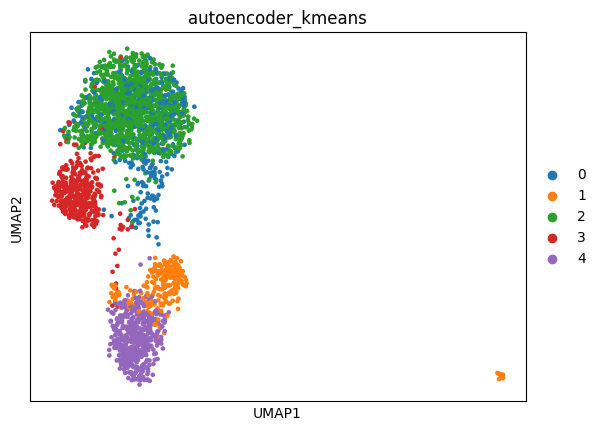

In [16]:
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['autoencoder_kmeans'])


In [18]:
silhouette_score_result = silhouette_score(encoded_X, clusters)
print("Silhouette Score for KMeans Clustering:", silhouette_score_result)


Silhouette Score for KMeans Clustering: 0.087967515


In [20]:
!pip install python-igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.0 MB/s eta 0:00:00


In [22]:
!pip install louvain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.1 MB/s eta 0:00:00


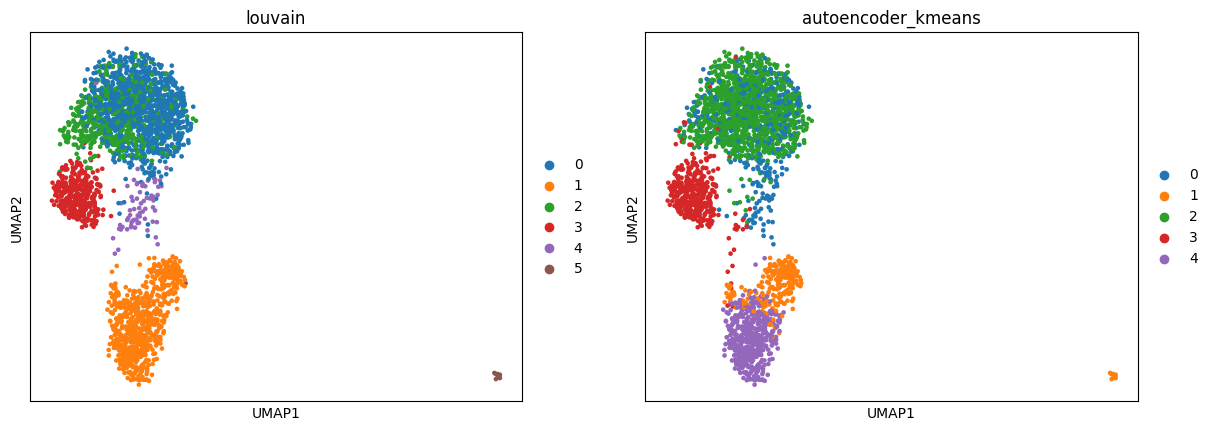

In [25]:
sc.tl.louvain(adata)
sc.pl.umap(adata, color=['louvain', 'autoencoder_kmeans'])


## Autoencoder + SOM

In [3]:
!pip install minisom scanpy tensorflow matplotlib seaborn


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.4 MB/s eta 0:00:00
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=0a7214cd24aa4842e6d86b2d05d14838f31128e75591fe70268937ca3b06e191
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


  0%|          | 0.00/5.58M [00:00<?, ?B/s]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13714)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     7,022,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13714)          │     7,035,282 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,125,522 (53.88 MB)

 Trainable params: 14,124,498 (53.88 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 28s 299ms/step - loss: 1.0135
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 326ms/step - loss: 0.9942
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 27s 323ms/step - loss: 0.9860
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 300ms/step - loss: 0.9783
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 295ms/step - loss: 0.9675
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 42s 310ms/step - loss: 0.9633
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 310ms/step - loss: 0.9564
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 303ms/step - loss: 0.9491
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 303ms/step - loss: 0.9436
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 301ms/step - loss: 0.9369
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 296ms/step - loss: 0.9294
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 294ms/step - loss: 0.9229
Epoch 13/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 42s 308ms/step - loss: 0.9142
Epoch 14/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 299ms/step - loss: 0.9066
Epoch 15/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 

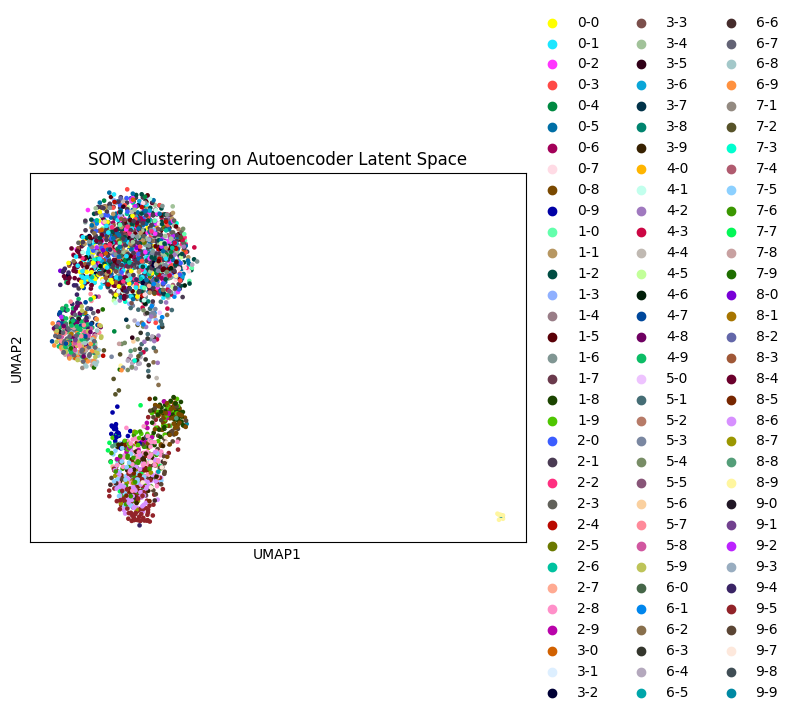

Silhouette Score: -0.03924031


In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from minisom import MiniSom

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Step 1: Load and preprocess data
adata = sc.datasets.pbmc3k()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

X = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X
X = StandardScaler().fit_transform(X)  # SOM benefits from normalized input

# Step 2: Build Autoencoder
input_dim = X.shape[1]
encoding_dim = 64

input_layer = Input(shape=(input_dim,))
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-5))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
encoded = Dense(encoding_dim, activation='relu')(x)
x = Dense(512, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(x)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer=Adam(1e-3), loss='mse')
autoencoder.summary()

# Step 3: Train autoencoder
autoencoder.fit(X, X, epochs=50, batch_size=32, shuffle=True, verbose=1)

# Step 4: Encode data using encoder
latent_X = encoder.predict(X)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 24.834909463215187


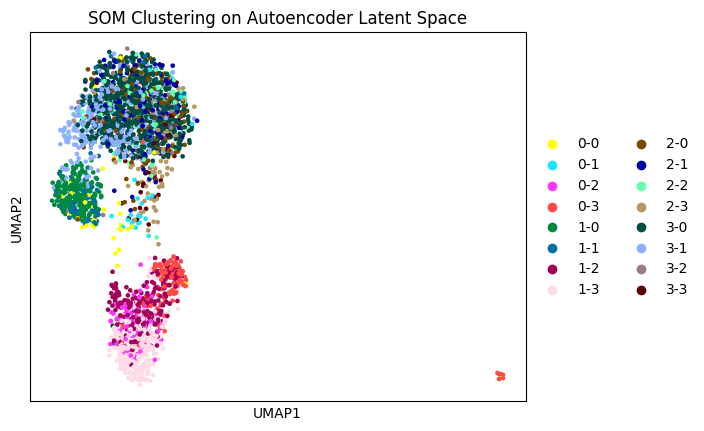

Silhouette Score: 0.017769776


In [6]:
# Step 5: SOM clustering
som_size = 4  # 10x10 SOM grid
som = MiniSom(x=som_size, y=som_size, input_len=encoding_dim, sigma=1.0, learning_rate=0.5)
som.random_weights_init(latent_X)
som.train_random(latent_X, 1000, verbose=True)

# Assign each data point to its best matching SOM node
win_map = np.array([som.winner(x) for x in latent_X])
clusters = [f"{i}-{j}" for i, j in win_map]  # Convert (i,j) to string label
adata.obs['som_cluster'] = clusters

# Step 6: Visualization
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['som_cluster'], title="SOM Clustering on Autoencoder Latent Space")

# Step 7: Evaluation (Optional - needs true labels or qualitative judgment)
print("Silhouette Score:", silhouette_score(latent_X, clusters))

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from minisom import MiniSom

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Step 1: Load and preprocess data
adata = sc.datasets.pbmc3k()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Extract matrix and scale it
X = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X
X = StandardScaler().fit_transform(X)

# Step 2: Build Autoencoder
input_dim = X.shape[1]
encoding_dim = 64

input_layer = Input(shape=(input_dim,))
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-5))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
encoded = Dense(encoding_dim, activation='relu')(x)
x = Dense(512, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(x)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer=Adam(1e-3), loss='mse')
autoencoder.summary()

# Step 3: Train Autoencoder
autoencoder.fit(X, X, epochs=5, batch_size=32, shuffle=True, verbose=1)

# Step 4: Get latent representation
latent_X = encoder.predict(X)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 13714)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     7,022,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 13714)          │     7,035,282 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,125,522 (53.88 MB)

 Trainable params: 14,124,498 (53.88 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 227ms/step - loss: 1.0159
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - loss: 0.9920
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - loss: 0.9849
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - loss: 0.9841
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 222ms/step - loss: 0.9695
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
 [ 3000 / 3000 ] 100% - 0:00:00 left 
 quantization error: 15.368816402720412


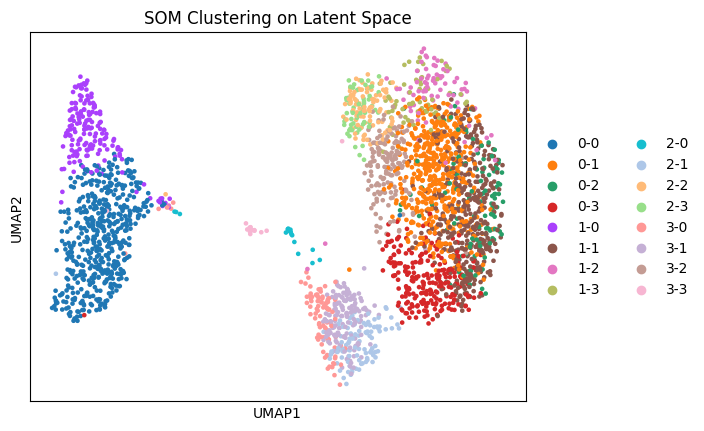

Silhouette Score: 0.06065823


In [ ]:


# Step 5: Train SOM
som_size = 4  # SOM grid size
som = MiniSom(x=som_size, y=som_size, input_len=encoding_dim, sigma=1.0, learning_rate=0.5)
som.random_weights_init(latent_X)
som.train_random(latent_X, 3000, verbose=True)  # Increased training steps

# Assign clusters from SOM nodes
win_map = np.array([som.winner(x) for x in latent_X])
clusters = [f"{i}-{j}" for i, j in win_map]
adata.obs['som_cluster'] = clusters

# Step 6: Visualize on latent space UMAP
adata.obsm['X_latent'] = latent_X
sc.pp.neighbors(adata, use_rep='X_latent')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['som_cluster'], title="SOM Clustering on Latent Space")

# Step 7: Evaluation
# Convert string clusters to numeric labels for silhouette score
from sklearn.preprocessing import LabelEncoder
numeric_labels = LabelEncoder().fit_transform(clusters)
sil_score = silhouette_score(latent_X, numeric_labels)
print("Silhouette Score:", sil_score)
